<a href="https://colab.research.google.com/github/ntsu/DAQ-Refine/blob/main/DAQ_Refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://user-images.githubusercontent.com/50850224/184964587-79a4e08d-4edd-4ef8-b69b-dfa8fe3b4804.png" align="left" style="height:240px">

#DAQ-refine: Protein Structure refinement by DAQ-score and ColabFold

This notebook contains a modified [ColabFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) and our tools.
To identify low quality regions in the protein structyure,
Please use [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing)

<br><br>

##Reference: <br>
[Terashi, G., Wang, X., Maddhuri Venkata Subramaniya, S.R., Kihara, D.. Residue-wise local quality estimation for protein models from cryo-EM maps. Nat Methods 19.9 (2022). https://doi.org/10.1038/s41592-022-01574-4](https://www.nature.com/articles/s41592-022-01574-4)<br>
[Terashi, G., Wang, X., Kihara, D.. Protein model refinement for cryo-EM maps using AlphaFold2 and the DAQ
score. Acta Cryst. D79 (2022). https://doi.org/10.1107/S2059798322011676](https://doi.org/10.1107/S2059798322011676)

---
#Instructions
DAQ-refine has two strategies for the model refinement with DAQ-score.
###Before starting DAQ-refine, please use [**DAQ-score**](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing) on Google Colab, and then download a result file (**daq_score_w9.pdb**). DAQ-refine uses this **daq_score_w9.pdb** as a template structure.

##**Strategy-1: DAQ-score + ColabFold with a trimmed template model.**
You need:
*   Output file of DAQ-score (**daq_score_w9.pdb**).

##**Strategy-2: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.**
You need:
* Output file of DAQ-score (**daq_score_w9.pdb**).
* A MSA file (**A3M format**).
 * If you do not have a MSA file, please use `Vanilla AlphaFold2` or [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).

##After the ColabFold part, Rosetta relax protocol with the EM map will improve the model quality further.
* [Rosetta relax tutorial](https://www.rosettacommons.org/docs/latest/application_documentation/structure_prediction/relax)

* [Scripts and Tutorials](https://dimaiolab.ipd.uw.edu/software/)


#STEP-0 Install Dependencies

In [2]:
#@title Install dependency
#@markdown maxit (for converting fille format PDB to CIF)<br>
#@markdown Just click `Run Cell` (the left button) or `Ctr+Enter` to run
! wget https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
! zcat maxit-v11.100-prod-src.tar.gz | tar -xf -
#configure our environment
import urllib.request

get_url= urllib.request.urlopen('https://kiharalab.org/emsuites/daq_refine_count.php?pwd=daq_dklab')
import os
RCSBROOT=os.path.join(os.getcwd(),"maxit-v11.100-prod-src")
os.environ['RCSBROOT']=RCSBROOT
os.environ['PATH'] += ":RCSBROOT$/bin"
%cd maxit-v11.100-prod-src
! sudo apt-get install bison
! sudo apt-get install flex
! sudo apt-get install csh
! sudo apt install bash-completion
! ls binary.csh
! make -j`nproc` binary
!csh binary.csh
!./bin/DictToSdb -ddlFile ./data/ascii/mmcif_ddl.dic -dictFile ./data/ascii/mmcif_pdbx.dic -dictSdbFile mmcif_pdbx.sdb
!mv mmcif_pdbx.sdb ./data/binary
!rm -f ./bin/DictToSdb ./bin/cif2bin ./bin/connect_main
!csh 'if [ -e ./mmcif_pdbx.dic-parser.log ]; then rm -rf ./mmcif_pdbx.dic-parser.log; fi'
import os
cur_path=os.getcwd()
script_path = os.path.join(cur_path,"bin")
script_path = os.path.join(script_path,"maxit")
os.environ["maxit"]=script_path
%cd ..

# running command in this notebook : !$maxit -input xx.pdb -output xx.cif -o 1 or maxit -input xx.cif -output xx.pdb -o 2

--2023-12-06 16:54:59--  https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
Resolving sw-tools.rcsb.org (sw-tools.rcsb.org)... 128.6.178.46
Connecting to sw-tools.rcsb.org (sw-tools.rcsb.org)|128.6.178.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75123919 (72M) [application/x-gzip]
Saving to: ‘maxit-v11.100-prod-src.tar.gz’

maxit-v11.100-prod- 100%[===================>]  71.64M  31.1MB/s    in 2.3s    

2023-12-06 16:55:01 (31.1 MB/s) - ‘maxit-v11.100-prod-src.tar.gz’ saved [75123919/75123919]

/content/maxit-v11.100-prod-src
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  bison-doc
The following NEW packages will be installed:
  bison
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 748 kB of archives.
After this operation, 2,519 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 bison amd64 2:

<a name='step1'></a>
# STEP-1: Input Protein Sequence and DAQ result file

1. Select the DAQ-refine strategy:
* **Vanilla AlphaFold2** : does not use the DAQ-score result.
* **Strategy-1**: DAQ-score + ColabFold with a trimmed template model.
* **Strategy-2**: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.

2. **If you select Strategy-1 or -2**, upload a result file (**daq_score_w9.pdb**) generated by [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing).

3. **If you select Strategy-2**, upload MSA file in **Input data** cell.

4. Runtime -> Run all


##Input data
<a name="template_mode"></a>

In [3]:
#@title Input data
#@markdown Select strategy
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def TrimDAQ(filename,cutoff,outfile):
    daq=[]
    PDB={}
    lines=''
    count_use=0
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM'):
                li=li.strip()
                resn = int(li[22:26])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                res_name=li[17:20]
                PDB[str(resn)]=[x,y,z,sco]
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
                else:
                    if res_name!="UNK":
                      lines=lines+li[:21]+'A'+li[22:]+'\n'
                    else:
                      lines=lines+li[:17]+"ALA A"+li[22:]+'\n'
                    count_use+=1
    if count_use<=0:
      print("All regions are detected Wrong by DAQ! DAQ-Refine can not work!")
      raise Exception("All regions are detected Wrong by DAQ! DAQ-Refine can not work!")

    #print(lines)
    with open(outfile,'w') as out:
        out.write(lines)

rand_letters = string.ascii_lowercase
dir_tmp=rand_letters
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
daq_file=''
str_mode = "strategy1" #@param ["Vanilla AF2","strategy1","strategy2"]
if str_mode == "strategy1" or str_mode == "strategy2":
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  print("Please Upload daq_score_w9.pdb (DAQ-score output file) HERE")
  pdb_input = files.upload()

  for fn in pdb_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(pdb_input[fn])))
    pdb_input_path = os.path.abspath(fn)
    print("PDB save to %s"%pdb_input_path)
    TrimDAQ(pdb_input_path,0.0,upload_dir+'/1tmp.pdb')
    #files.download(upload_dir+'/1tmp.pdb')
    #convert PDB to CIF
    !$maxit -input 1tmp.pdb -output 1tmp.cif -o 1
    #files.download(upload_dir+'/1tmp.cif')
    daq_file=upload_dir+'/1tmp.cif'
  os.chdir(root_dir)


#@title Prepare a trimmed template model

##Use Colab Fold Part
from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown Input target sequence
query_sequence = 'MSLSEGQVHRFLDQNPGFADQYFGRKLSPEDVANACEDGCPEGCTSFRELCQVEESAALFELVQDMQENVNMERVVFKILRRLCSILHADRCSLFMYRQRNGVAELATRLFSVQPDSVLEDCLVPPDSEIVFPLDIGVVGHVAQTKKMVNVQDVMECPHFSSFADELTDYVTRNILATPIMNGKDVVAVIMAVNKLDGPCFTSEDEDVFLKYLNFGTLNLKIYHLSYLHNCETRRGQVLLWSANKVFEELTDIERQFHKAFYTVRAYLNCDRYSVGLLDMTKEKEFFDVWPVLMGEAQAYSGPRTPDGREILFYKVIDYILHGKEDIKVIPSPPADHWALASGLPTYVAESGFICNIMNAPADEMFNFQEGPLDDSGWIVKNVLSMPIVNKKEEIVGVATFYNRKDGKPFDEQDEVLMESLTQFLGWSVLNTDTYDKMNKLENRKDIAQDMVLYHVRCDREEIQLILPTRERLGKEPADCEEDELGKILKEVLPGPAKFDIYEFHFSDLECTELELVKCGIQMYYELGVVRKFQIPQEVLVRFLFSVSKGYRRITYHNWRHGFNVAQTMFTLLMTGKLKSYYTDLEAFAMVTAGLCHDIDHRGTNNLYQMKSQNPLAKLHGSSILERHHLEFGKFLLSEETLNIYQNLNRRQHEHVIHLMDIAIIATDLALYFKKRTMFQKIVDESKNYEDRKSWVEYLSLETTRKEIVMAMMMTACDLSAITKPWEVQSKVALLVAAEFWEQGDLERTVLDQQPIPMMDRNKAAELPKLQVGFIDFVCTFVYKEFSRFHEEILPMFDRLQNNRKEWKALADEYEAKVKALEEDQKKETTAKKVGTEICNGGPAPRSSTCRIL' #@param {type:"string"}

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = '7jsn_b' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
use_amber = num_relax > 0
#use_amber = False #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - This option is only active for Vanilla AF mode.
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))


if str_mode == "strategy1" or str_mode == "strategy2":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  #uploaded = files.upload()
  use_templates = True
  #for fn in uploaded.keys():
  fn = daq_file
  os.rename(fn, f"{jobname}_template/1tmp.cif")
  template_mode = "custom"
elif template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False

##MSA part##
def trim_a3m(a3m,daq,good):
    out=[]
    for ith in range(len(a3m)):
        name,seq = a3m[ith]
        new_seq=''
        if ith == 0:#query
            new_seq = seq
        else:
            pos=0
            for aa in seq:
                if aa == aa.lower() and aa != '-':
                    continue
                pos = pos + 1
                if pos in daq: #selected bad regions or missing regions
                    new_seq = new_seq + aa
                elif not pos in good:
                    new_seq = new_seq + aa
                elif aa == aa.upper():
                    new_seq = new_seq + '-'
        out.append([name,new_seq])
    return out

def ReadA3M(filename):
    A3M=[]
    with open(filename) as f:
        for li in f:
            if li.startswith('#'):
                continue
            if li.startswith('>'):
                name = li.strip()
            else:
                seq = li.strip()
                A3M.append([name,seq])
    return A3M

def ReadDAQ(filename,cutoff,dist_cut):
    daq=[]
    PDB={}
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM') and li[13:16]=='CA ':
                li=li.strip()
                resn = int(li[23:27])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                PDB[str(resn)]=[x,y,z,sco]
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
    print(daq)
    daq2=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        #Distance check
        x1=PDB[resn][0]
        y1=PDB[resn][1]
        z1=PDB[resn][2]
        for resn2 in PDB:
            if not int(resn2) in daq:
                continue
            x2=PDB[resn2][0]
            y2=PDB[resn2][1]
            z2=PDB[resn2][2]
            dist=(x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2)
            if dist <=dist_cut*dist_cut:#close
                daq2.append(int(resn))
                break
    #print('LowDAQ',daq,'Extended',daq2)
    daq=list(set(daq+daq2))
    #Others
    goodpos=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        goodpos.append(int(resn))
    print('HighDAQ',goodpos)

    return daq,goodpos

def save_a3m(file,a3m):
    lines=''
    for name,seq in a3m:
        lines = lines + name+'\n'
        lines = lines + seq+'\n'
    with open(file,'w') as out:
        out.write(lines)

#Use MSA
if str_mode == "strategy2":
  root_dir = os.getcwd()
  print(root_dir)
  print('Please upload MSA file (a3m format)')
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  cust_msa_input = files.upload()

  if not os.path.isfile(pdb_input_path):
    print('Can not find DAQ-score output file!!')


  for fn in cust_msa_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(cust_msa_input[fn])))
    cust_msa_path = os.path.abspath(fn)
    print("MSA save to %s"%cust_msa_path)
    a3m=ReadA3M(cust_msa_path)
    daq,good=ReadDAQ(pdb_input_path,0.0,0.0)
    new_a3m=trim_a3m(a3m,daq,good)
    filename=upload_dir+'/trimmed_msa.a3m'
    save_a3m(filename,new_a3m)
    daq_msa = filename
    #files.download(filename)
  os.chdir(root_dir)

Please Upload daq_score_w9.pdb (DAQ-score output file) HERE


Saving 22458_7jsn_B_v1-1_w9.pdb to 22458_7jsn_B_v1-1_w9.pdb
User uploaded file "22458_7jsn_B_v1-1_w9.pdb" with length 1052116 bytes
PDB save to /content/fefbqyqndwwsmmhmdnaa/22458_7jsn_B_v1-1_w9.pdb


<a name='step2'></a>
#STEP-2: Modeling Part (by ColabFold)


### MSA options (custom MSA upload)
<a name="msa_options"></a>

In [4]:

#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.



# decide which a3m to use
if str_mode == "strategy2":
  msa_mode = "custom"
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    #custom_msa_dict = files.upload()
    #custom_msa = list(custom_msa_dict.keys())[0]
    custom_msa = daq_msa
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
elif msa_mode.startswith("mmseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

## Advanced setting and Install dependencies

In [5]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "1" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.



In [6]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/kiharalab/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")


installing colabfold...
installing conda...
installing hhsuite...
CPU times: user 442 ms, sys: 72.8 ms, total: 514 ms
Wall time: 1min 46s


##Run Prediction
Ctr + Enter

2023-12-06 17:04:05,394 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2023-12-06 17:04:05,396 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-12-06 17:04:10,698 Running on GPU
2023-12-06 17:04:11,167 Found 7 citations for tools or databases
2023-12-06 17:04:11,437 Adding missing field revision_date to 7jsn_b_2946e_template/1tmp.cif. Backing up original file to 7jsn_b_2946e_template/1tmp.cif.bak.
2023-12-06 17:04:11,815 Query 1/1: 7jsn_b_2946e (length 853)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:13 remaining: 00:00]


2023-12-06 17:04:32,244 Sequence 0 found templates: ['1tmp_A', '1tmp_A', '1tmp_A', '1tmp_A']


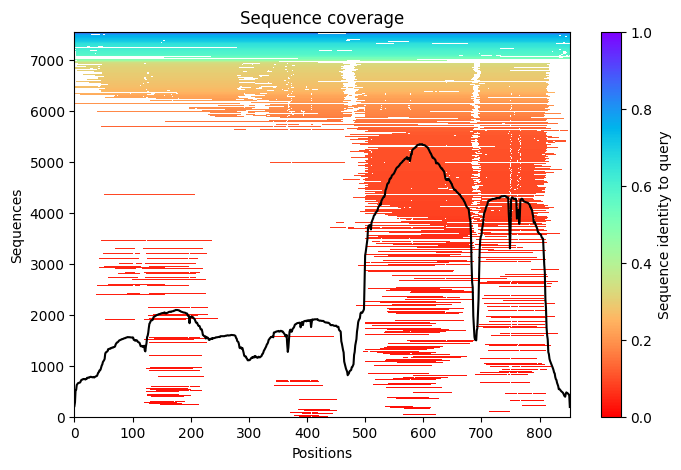

2023-12-06 17:04:35,182 Setting max_seq=512, max_extra_seq=5120
2023-12-06 17:09:40,654 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=83.5 pTM=0.618
2023-12-06 17:13:41,588 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.7 pTM=0.651 tol=1.44
2023-12-06 17:13:41,597 alphafold2_ptm_model_1_seed_000 took 518.9s (1 recycles)


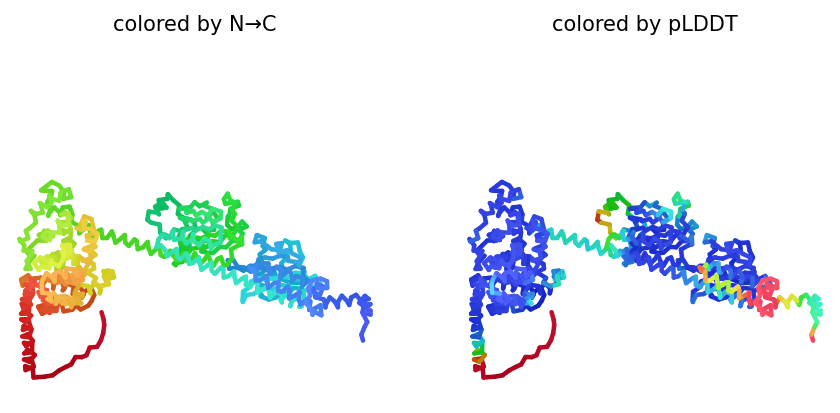

2023-12-06 17:17:43,177 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=85.2 pTM=0.711
2023-12-06 17:21:44,481 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=86.8 pTM=0.747 tol=0.75
2023-12-06 17:21:44,490 alphafold2_ptm_model_2_seed_000 took 481.2s (1 recycles)


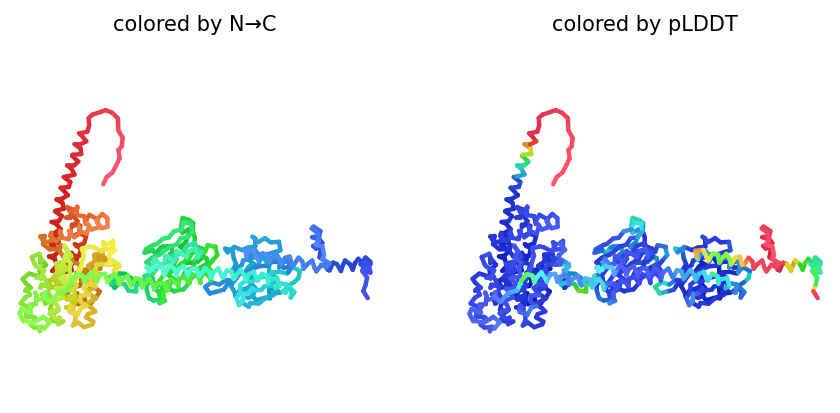

2023-12-06 17:25:56,152 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=86.6 pTM=0.631
2023-12-06 17:29:42,118 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=88.7 pTM=0.679 tol=2.38
2023-12-06 17:29:42,123 alphafold2_ptm_model_3_seed_000 took 476.3s (1 recycles)


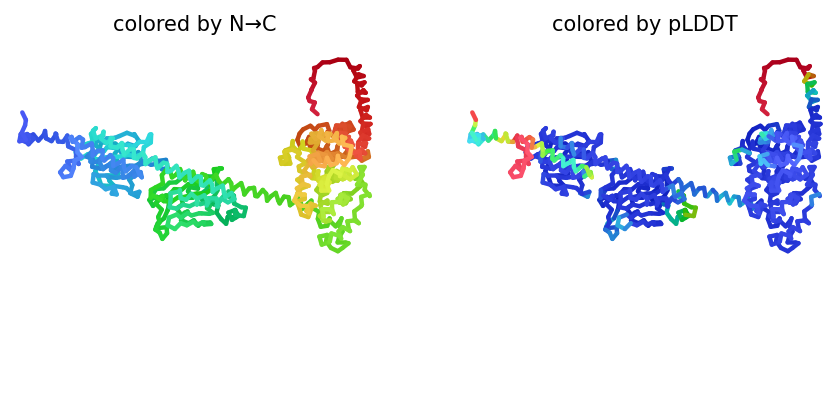

2023-12-06 17:33:29,151 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=85.6 pTM=0.714
2023-12-06 17:37:15,155 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=88.4 pTM=0.757 tol=2.08
2023-12-06 17:37:15,160 alphafold2_ptm_model_4_seed_000 took 451.7s (1 recycles)


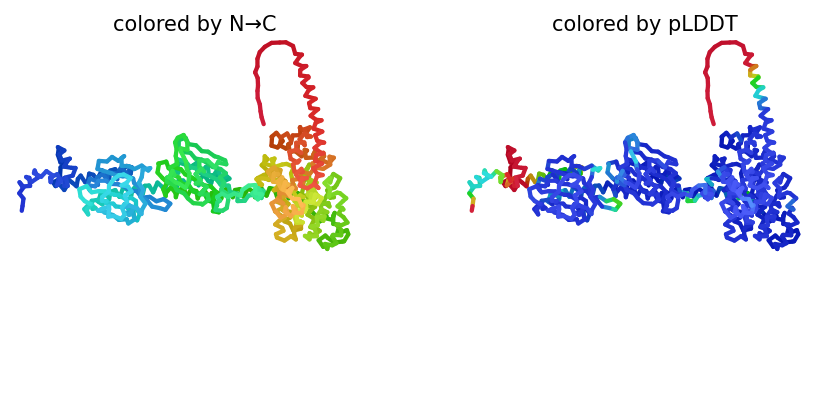

2023-12-06 17:41:02,265 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=85.2 pTM=0.673
2023-12-06 17:44:48,910 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=87.6 pTM=0.731 tol=3.16
2023-12-06 17:44:48,920 alphafold2_ptm_model_5_seed_000 took 452.5s (1 recycles)


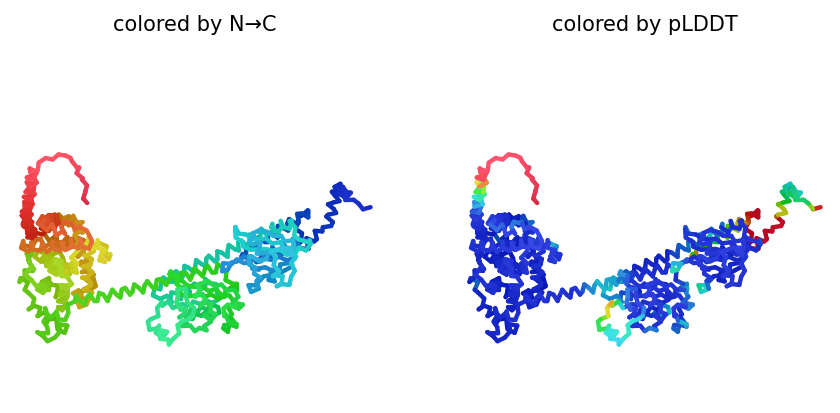

2023-12-06 17:44:50,602 reranking models by 'plddt' metric
2023-12-06 17:44:50,604 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=88.7 pTM=0.679
2023-12-06 17:44:50,604 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=88.4 pTM=0.757
2023-12-06 17:44:50,605 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=87.6 pTM=0.731
2023-12-06 17:44:50,606 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=86.8 pTM=0.747
2023-12-06 17:44:50,607 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=85.7 pTM=0.651
2023-12-06 17:44:54,817 Done


0

In [7]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

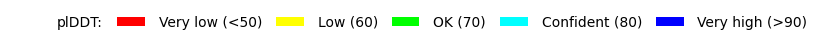

In [8]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


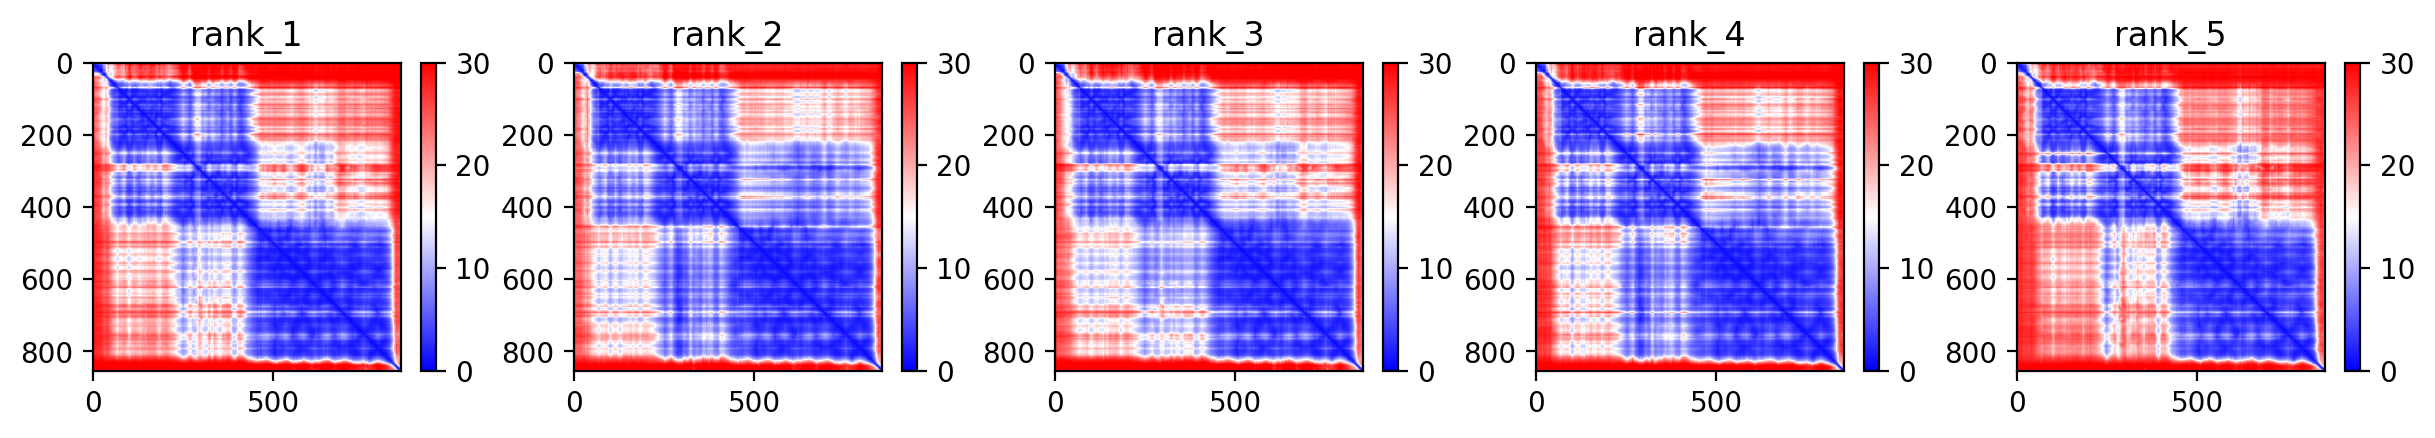
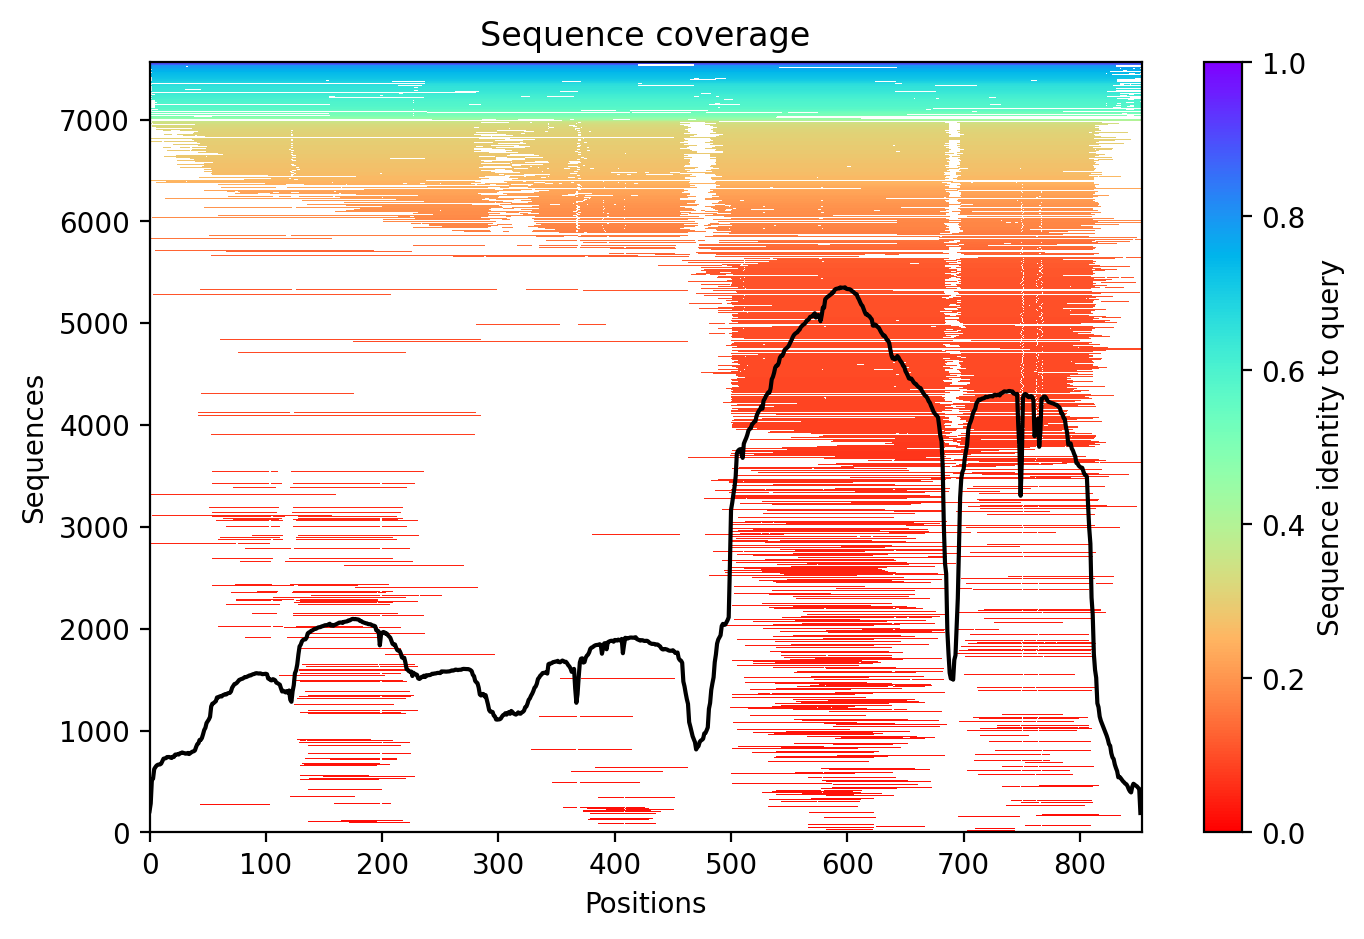
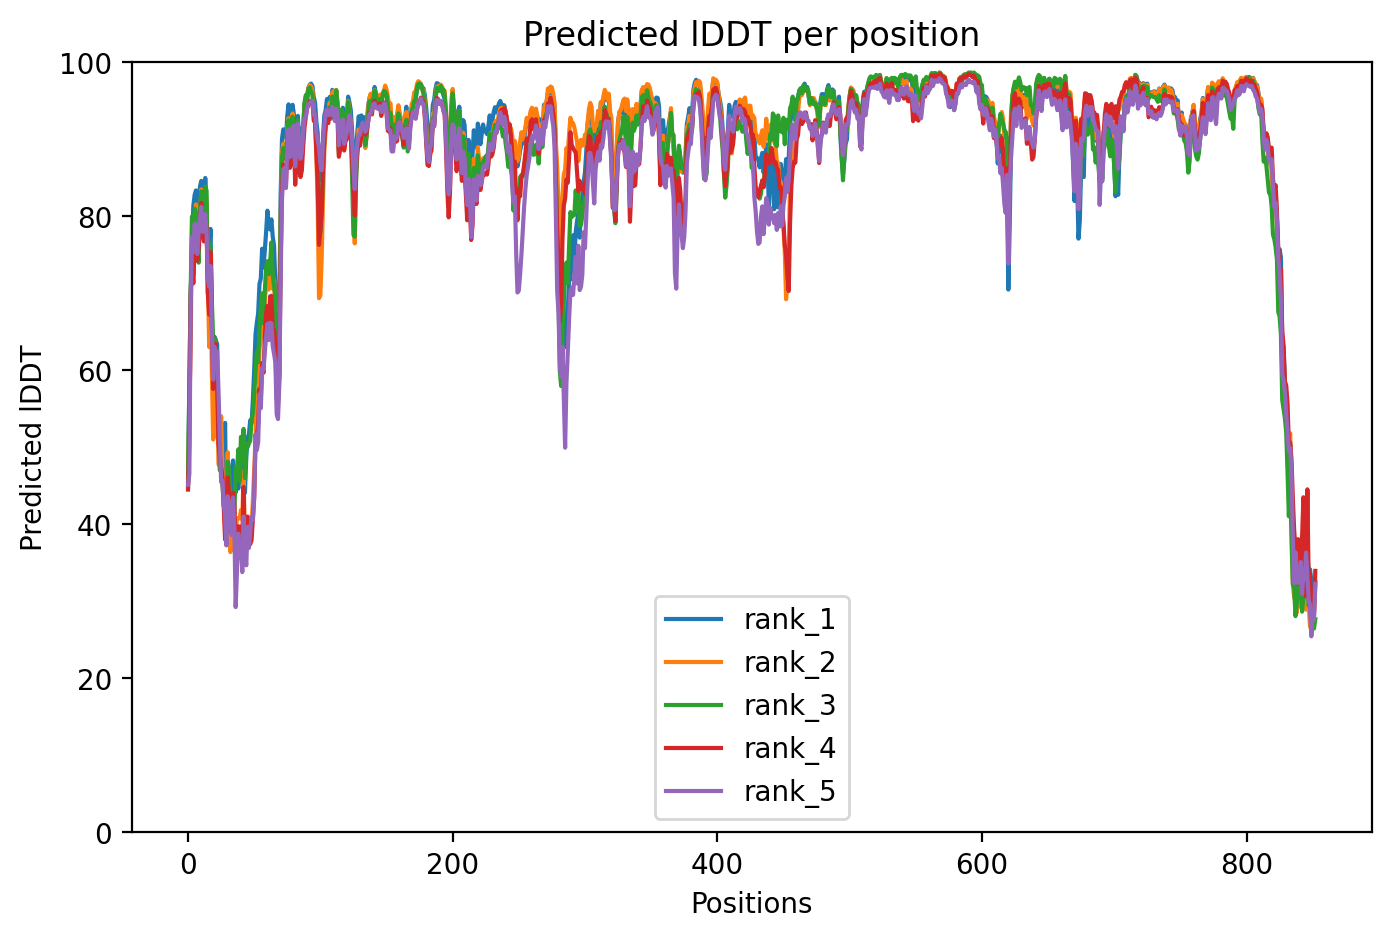

In [9]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

<a name='step2'></a>
#STEP-3: Compute refined DAQ score (Optional)

In [10]:
#@title Install dependencies{run: "auto"}
!git clone https://github.com/kiharalab/DAQ
!pip install -r ./DAQ/requirements.txt --user
import requests
url = "https://zhanggroup.org/MM-align/bin/module/MMalign.cpp"
response = requests.get(url)
with open("MMalign.cpp", "wb") as f:
  f.write(response.content)
!g++ -static -O3 -ffast-math -o MMalign MMalign.cpp


Cloning into 'DAQ'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 609 (delta 70), reused 108 (delta 35), pack-reused 448
Receiving objects: 100% (609/609), 79.48 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (320/320), done.
Updating files: 100% (160/160), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.3 MB/s eta 0:00:00
  Obtaining dependency information for numpy>=1.19.4 from https://files.pythonhosted.org/packages/64/41/284783f1014685201e447ea976e85fed0e351f5debbaf3ee6d7645521f1d/numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.4 MB/s eta 0:00:00
  Obtaining dependency information for numba>=0.52.0 from https://files.pythonhosted.org/packages/ed/13/b66627125b35f2987bd9872cf028b5e1e1ffcbc8d1e182ac4e84eed3998f/numba-0.58.1-cp310-cp310-manylinux2014_x86_64.manylinux

In [11]:
#@title Input DAQ-score output file if Vanilla strategy was selected
#@markdown if the selected DAQ-refine strategy is Vanilla AlphaFold2, please upload a result file (daq_score_w9.pdb) generated by DAQ-score colab in order to align the refined model to original model.
if str_mode == "Vanilla AF2":
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  print("Please Upload daq_score_w9.pdb (DAQ-score output file) HERE")
  pdb_input = files.upload()

  for fn in pdb_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(pdb_input[fn])))
    pdb_input_path = os.path.abspath(fn)
    print("PDB save to %s"%pdb_input_path)
  os.chdir(root_dir)

In [12]:
#@title Input cryo-EM map <a name="Map"></a>
#@markdown **Please make sure the cryo-EM map is aligned with the predicted structure.**
#@markdown <br>Here we suggest user to upload a cryo-EM map with **spacing 1** to save the running time. Detailed instructions with ChimeraX is <a href="#ChimeraX">ChimeraX resampling</a>
#@markdown <br> **Support file format: .mrc, .mrc.gz**
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

rand_letters = string.ascii_lowercase
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
root_dir = os.getcwd()
upload_dir = os.path.join(root_dir,rand_letters)
if not os.path.exists(upload_dir):
  os.mkdir(upload_dir)
os.chdir(upload_dir)
map_input = files.upload()
for fn in map_input.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name=fn, length=len(map_input[fn])))
  map_input_path = os.path.abspath(fn)
  print("Map save to %s"%map_input_path)
os.chdir(root_dir)

Saving emd_22458.map.gz to emd_22458.map.gz
User uploaded file "emd_22458.map.gz" with length 102220704 bytes
Map save to /content/zwwulqdyuqhfglnbqwtr/emd_22458.map.gz


In [13]:
from google.colab import files
import os
import os.path
import re
import hashlib
#@markdown Specify other parameters(optional) <a name="Param"></a>
#contour = '0' #@param {type:"string"}
# ```author recommended contour level for the input map. Using contour level will not have any impact on the result, but can reduce the computation time. ```
# <br>```default:0. Suggested Range: [0,author_contour]```
half_window_size = '9' #@param {type:"string"}
#@markdown ```window size is used for smoothing the residue-wise score based on a sliding window scanning the entire sequence.```
#@markdown <br> ```Here whole_window_size=(half_window_size*2+1) ```<br>```default half_window_size: 9(integer). Suggested Range: [1,9]. ```
stride = '2'#@param {type:"string"}
#@markdown Detailed explanation can be seen: [stride_definition](https://deepai.org/machine-learning-glossary-and-terms/stride)<br>
#@markdown ```stride step for scanning the cryo-EM map. Increasing the stride can reduce the computation time but may lead to unreliable result. ```<br>``` default stride: 1(integer). Suggested range: [1,4].```
batch_size = '512'#default param

In [14]:
#@title Run DAQ <a name="Running"></a>
#@markdown Please allow 5min-2hours to get the output, since 3D input processing and inferencing takes some time.
#@markdown <br>Our running time is directly correlated to the size of the structures. For example, a map with 50 * 50 * 50 can take 3 minutes to finish when you set stride=1.
#@markdown <br>If your structure is too big, you can use stride=2 in last step.
new_pdb = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_rank_001_*.pdb"
print(new_pdb)
%cd /
%cd content
!pwd
new_pdb_path=glob.glob(new_pdb)
print(new_pdb_path)
final_pdb_path=new_pdb_path[0]
import shutil
shutil.copy(final_pdb_path,"DAQ/input.pdb")
shutil.copy(map_input_path,"DAQ/input.mrc")
shutil.copy(map_input_path,"input.mrc")
if str_mode == "strategy1" or str_mode == "strategy2":
  ! ./MMalign $final_pdb_path $pdb_input_path -o DAQ/input.pdb
  %cd DAQ
  !python main.py --mode=0 -F input.mrc -P input.pdb --window $half_window_size --stride $stride
else:
  %cd DAQ
  !python main.py --mode=0 -F input.mrc -P input.pdb --window $half_window_size --stride $stride




7jsn_b_2946e/7jsn_b_2946e_unrelaxed_rank_001_*.pdb
/
/content
/content
['7jsn_b_2946e/7jsn_b_2946e_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb']

Name of Structure_1: 7jsn_b_2946e/7jsn_b_2946e_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb:A (to be superimposed onto Structure_2)
Name of Structure_2: /content/fefbqyqndwwsmmhmdnaa/22458_7jsn_B_v1-1_w9.pdb:B
Length of Structure_1: 853 residues
Length of Structure_2: 807 residues

Aligned length= 785, RMSD=   3.57, Seq_ID=n_identical/n_aligned= 0.699
TM-score= 0.83073 (normalized by length of Structure_1: L=853, d0=9.89)
TM-score= 0.87470 (normalized by length of Structure_2: L=807, d0=9.67)
(You should use TM-score normalized by length of the reference structure)

(":" denotes residue pairs of d < 5.0 Angstrom, "." denotes other aligned residues)
MSLSEGQ-VHRFLDQNP-G----FADQYFG-RKLSPEDVAN-----ACEDGCPEGCTSFRELCQVEESAALFELVQDMQENVNMERVVFKILRRLCSILHADRCSLFMYRQRNGVAELATRLFSVQPDSVLEDCLVPPDSEIVFPLDIGVVGHVAQTKKMVNVQDVMECPHFSSFA

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

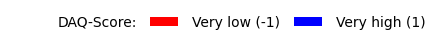

In [15]:
#@title Structure Quality Visualization (3D) <a name="Visualization"></a>
#get the generated pdb path
import os
window_size = half_window_size
download_path = os.path.join(os.getcwd(),"Predict_Result")
# map_name = os.path.split(map_input_path)[1].replace(".mrc","")
# map_name = map_name.replace(".gz","")
# map_name = map_name.replace("(","").replace(")","")
map_name="input"
output_pdb_path = os.path.join(download_path,map_name)
output_pdb_path2 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+".pdb")
final_pdb_path = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_reverse.pdb")
#print(os.path.getsize(output_pdb_path))
def reverse_pdb(filename,new_file_name):

    with open(filename,"r") as rfile:
      with open(new_file_name,'w') as wfile:
        for l in rfile:
            #print(l)
            if(l.startswith('ATOM')):
                sco=float(l[61:67])
                line = l[:60]+"%6.2f"%(sco)+"\n"
                wfile.write(line)
reverse_pdb(output_pdb_path2,final_pdb_path)
import matplotlib.pyplot as plt
def plot_plddt_legend():
  thresh = ['DAQ-Score:','Very low (-1)','Very high (1)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
#exit()
#Visualize
import py3Dmol
def show_pdb(output_pdb_path):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(output_pdb_path,'r').read(),'pdb')
  view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient':'rwb','min':-1,'max':1}}})
  #view.setStyle({'cartoon': {'color':'spectrumb'}})
  #view.setStyle({'cartoon': {'spectrum': {'prop':'b','min':-1,'max':1}}})
  view.zoomTo()
  return view
show_pdb(final_pdb_path).show()
plot_plddt_legend().show()

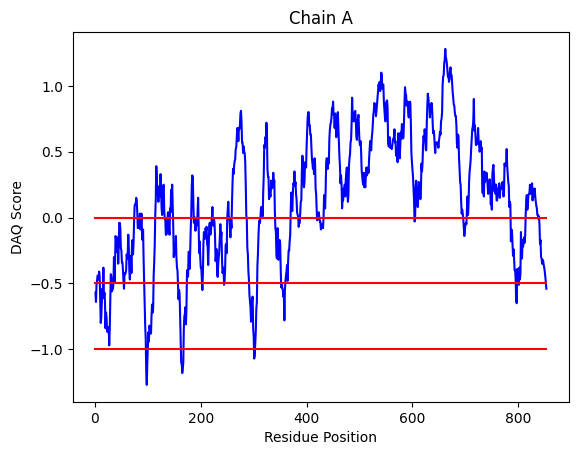

In [16]:
from typing import ContextManager
#@title Residue-wise Quality Plot (2D) <a name="Plot"></a>
import numpy as np
window_size = int(half_window_size)
def get_score(filename):
    p={}
    with open(filename) as result:
        for l in result:
            #print(l)
            if(l.startswith('ATOM') and l[12:16].replace(" ","") == 'CA'):

                #print('|'+l[30:38]+'|'+l[38:46]+'|'+l[46:54]+'|',resn)
                l = l.strip("\n")
                split_result = l.split()
                resn=int(float(l[22:26]))
                p[resn]=float(split_result[-1])
    return p
import matplotlib.pyplot as plt
def plot_relationship(x_input,y_input,x_label,y_label,title=None):
  plt.clf()
  plt.plot(x_input,y_input,"b-")
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  y_line1 = np.ones(len(x_input))*0
  y_line2 = -np.ones(len(x_input))*0.5
  y_line3 = -np.ones(len(x_input))*1.0
  plt.plot(x_input,y_line1,"r-")
  plt.plot(x_input,y_line2,"r-")
  plt.plot(x_input,y_line3,"r-")
  if title is not None:
    plt.title(title)
  return plt

#print(os.path.getsize(output_pdb_path))
def reverse_pdb(filename,new_file_name):

    with open(filename,"r") as rfile:
      with open(new_file_name,'w') as wfile:
        for l in rfile:
            #print(l)
            if(l.startswith('ATOM')):
                sco=float(l[61:67])
                line = l[:60]+"%6.2f"%(sco)+"\n"
                wfile.write(line)
def read_chain_set(filename):
    #read each residues for all other informations
    chain_set = set()
    with open(filename) as result:
        for l in result:
            if l.startswith('ATOM'):
                chain_name = l[21]
                chain_set.add(chain_name)
    return chain_set
import os
download_path = os.path.join(os.getcwd(),"Predict_Result")
# map_name = os.path.split(map_input_path)[1].replace(".mrc","")
# map_name = map_name.replace(".gz","")
# map_name = map_name.replace("(","").replace(")","")
map_name="input"
output_pdb_path = os.path.join(download_path,map_name)
output_pdb_path2 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+".pdb")
chain_list = read_chain_set(output_pdb_path2)
chain_list = list(chain_list)
chain_list.sort()
for chain_name in chain_list:
  output_pdb_path3 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_"+str(chain_name)+".pdb")
  final_pdb_path3 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_reverse.pdb")
  reverse_pdb(output_pdb_path3,final_pdb_path3)
  final_pdb_path3 = output_pdb_path3
  score_dict = get_score(final_pdb_path3)
  res_list = list(score_dict.keys())
  score_list = list(score_dict.values())
  plt_handler = plot_relationship(res_list,score_list,"Residue Position","DAQ Score","Chain "+str(chain_name))
  plt_handler.show()
#@markdown ***Residues with a DAQ-score of below these three cutoff values may not be correct, and thus worthwhile to check.***

In [17]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
%cd /
%cd content
if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

/
/content
	zip warning: name not matched: config.json
	zip warning: name not matched: cite.bibtex
deleting: 7jsn_b_2946e/
deleting: 7jsn_b_2946e/cite.bibtex
deleting: 7jsn_b_2946e/7jsn_b_2946e.done.txt
deleting: 7jsn_b_2946e/log.txt
deleting: 7jsn_b_2946e/7jsn_b_2946e_env/
deleting: 7jsn_b_2946e/7jsn_b_2946e_env/msa.sh
deleting: 7jsn_b_2946e/7jsn_b_2946e_env/pdb70.m8
deleting: 7jsn_b_2946e/7jsn_b_2946e_env/out.tar.gz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References
```
@article{genki2022DAQ,   
  title={Residue-Wise Local Quality Estimation for Protein Models from Cryo-EM Maps},   
  author={Genki Terashi, Xiao Wang, Sai Raghavendra Maddhuri Venkata Subramaniya, John J. G. Tesmer, and Daisuke Kihara},    
  journal={Nature Methods},    
  year={2022}    
}   
```
```
@article{genki2022daqrefine,   
  title={Protein model refinement for cryo-EM maps using AlphaFold2 and the DAQ score},   
  author={Genki Terashi, Xiao Wang, and Daisuke Kihara},    
  journal={Acta Cryst},    
  year={2022}    
}   
```

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Detail Instructions of ColabFold part
- Please check [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

**License**
The source code of DAQ-score and DAQ-refine are licensed under GPL v3. (If you are interested in a different license, for example, for commercial use, please contact [us](dkihara@purdue.edu).)

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

